# Super Resolution audio diffusion

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/super-resolution-audio-diffusion](https://github.com/huseinzol05/malaya-speech/tree/master/example/super-resolution-audio-diffusion).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages. Pretrained models trained on multilanguages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

<div class="alert alert-warning">

Required PyTorch >= 1.10.
    
</div>

Purpose of this module to increase sample rate.

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline
import IPython.display as ipd

In [2]:
import logging

logging.basicConfig(level=logging.INFO)

### List available audio diffusion deep models

In [3]:
malaya_speech.super_resolution.available_audio_diffusion()

INFO:malaya_speech.super_resolution:Only calculate SDR, ISR, SAR on voice sample. Higher is better.


,Size (MB)
nuwave2,20.9


### Load audio diffusion deep model

```python
def audio_diffusion(model: str = 'nuwave2', **kwargs):
    """
    Load audio diffusion based Speech Resolution.

    Parameters
    ----------
    model : str, optional (default='nuwave2')
        Model architecture supported. Allowed values:

        * ``'nuwave2'`` - originally from https://github.com/mindslab-ai/nuwave2.

    Returns
    -------
    result : malaya_speech.torch_model.super_resolution.NuWave2
    """
```

In [4]:
model = malaya_speech.super_resolution.audio_diffusion(model = 'nuwave2')

INFO:malaya_boilerplate.huggingface:downloading frozen huseinzol05/nuwave2/model.pth


### Important factor

1. Currently audio diffusion only able to upsample up to 48000 sampling rate.

### Predict

```python
def predict(self, input, sr: int, steps: int = 8):
    """
    Parameters
    ----------
    input: np.array
        np.array or malaya_speech.model.frame.Frame,
        prefer 8000, 12000, 16000 or 22050 or 44000 sampling rate.
    sr: int
        sampling rate, prefer 8000, 12000, 16000 or 22050 or 44000 sampling rate.
    steps: int, optional (default=8)
        diffusion steps.

    Returns
    -------
    result: np.array with 48k sampling rate
    """
```

In [5]:
import librosa
import matplotlib.pyplot as plt

In [6]:
sampling_rate = 44100
fft_size = 2048
hop_size = 256
win_length = None
window = 'hann'
num_mels = 128
fmin = 0
fmax = None

mel_basis = librosa.filters.mel(
    sr=sampling_rate,
    n_fft=fft_size,
    n_mels=num_mels,
    fmin=fmin,
    fmax=fmax,
)

In [7]:
y, sr_ = malaya_speech.load('speech/call-centre/1.wav', sr = None)
y = y[sr_ * 5 :sr_ * 7]
sr_

8000

In [8]:
ipd.Audio(y, rate = sr_)

In [9]:
%%time

output = model(y, sr = sr_)
ipd.Audio(output, rate = 48000)

/Users/huseinzolkepli/Documents/malaya-speech/malaya_speech/train/model/nuwave2_torch/model.py:108: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/SpectralOps.cpp:979.)
  center=True, normalized=True, onesided=True)


CPU times: user 2min 21s, sys: 34.5 s, total: 2min 56s
Wall time: 46.1 s


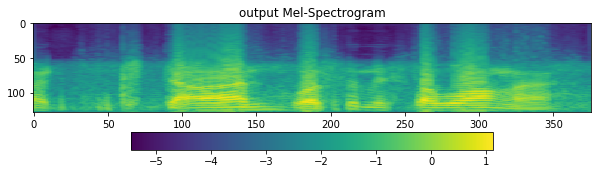

In [11]:
D = librosa.stft(
    output,
    n_fft=fft_size,
    hop_length=hop_size,
    win_length=win_length,
    window=window,
    pad_mode='reflect',
)
S, _ = librosa.magphase(D)
mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('output Mel-Spectrogram')
im = ax1.imshow(np.rot90(mel), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

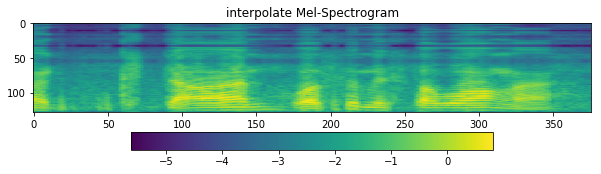

In [14]:
D = librosa.stft(
    malaya_speech.resample(y, sr_, 48000),
    n_fft=fft_size,
    hop_length=hop_size,
    win_length=win_length,
    window=window,
    pad_mode='reflect',
)
S, _ = librosa.magphase(D)
mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('interpolate Mel-Spectrogram')
im = ax1.imshow(np.rot90(mel), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

### Use Pipeline

Incase your audio is too long and you do not want to burden your machine. So, you can use malaya-speech Pipeline to split the audio splitted to 1 second, predict one-by-one and combine after that.

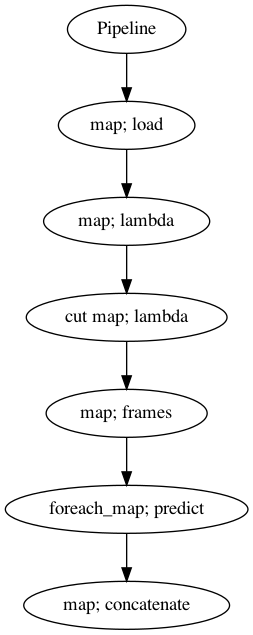

In [39]:
p = Pipeline()
pipeline = (
    p.map(malaya_speech.load, sr = sr_)
    .map(lambda x: x[0])
    .map(lambda x: x[sr_ * 5: sr_ * 10], name = 'cut')
    .map(malaya_speech.generator.frames, frame_duration_ms = 1200, sample_rate = sr_, append_ending_trail = False)
    .foreach_map(model.predict, sr = sr_)
    .map(np.concatenate)
)
p.visualize()

In [40]:
%%time

results = p('speech/call-centre/1.wav')

CPU times: user 6min 16s, sys: 1min 34s, total: 7min 50s
Wall time: 2min 6s


In [41]:
ipd.Audio(results['concatenate'], rate = 48000)

In [42]:
resampled = malaya_speech.resample(results['cut'], sr_, 48000)

In [44]:
ipd.Audio(resampled, rate = 48000)

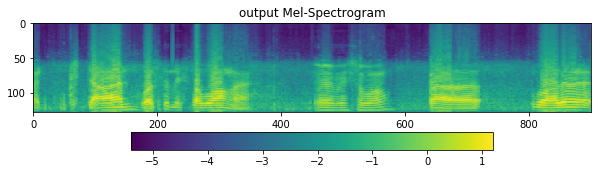

In [45]:
D = librosa.stft(
    results['concatenate'],
    n_fft=fft_size,
    hop_length=hop_size,
    win_length=win_length,
    window=window,
    pad_mode='reflect',
)
S, _ = librosa.magphase(D)
mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('output Mel-Spectrogram')
im = ax1.imshow(np.rot90(mel), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

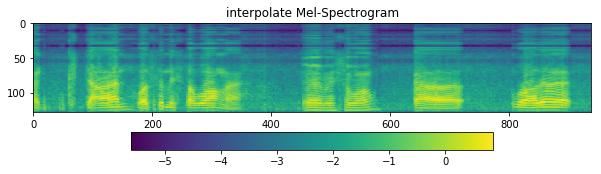

In [46]:
D = librosa.stft(
    resampled,
    n_fft=fft_size,
    hop_length=hop_size,
    win_length=win_length,
    window=window,
    pad_mode='reflect',
)
S, _ = librosa.magphase(D)
mel = np.log10(np.maximum(np.dot(mel_basis, S), 1e-10)).T
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('interpolate Mel-Spectrogram')
im = ax1.imshow(np.rot90(mel), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()